In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import hhclustering as hc
import utils 

from importlib import reload
reload(utils)

from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from numba import njit

In [2]:
# Load dataset
with open("./data/align_data_sub.pkl", 'rb') as fp:
    align_data_sub = pkl.load(fp)
    
data = align_data_sub["data"].copy()
echelon = np.array([c["rank"] for c in align_data_sub["col_names"]])

# PCA projected datset
eval, evec, _, cov_mat = hc.pca(data)
pca_proj = np.dot(evec.T, data)

def show_pca_proj(pred_labels, **kwargs):
    plt.scatter(pca_proj[0], pca_proj[1], c=pred_labels, s=1, **kwargs)

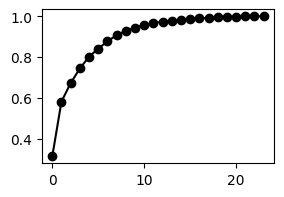

In [3]:
plt.figure(figsize=(3, 2))
plt.plot(np.cumsum(eval/np.sum(eval)), 'ko-')
plt.show()

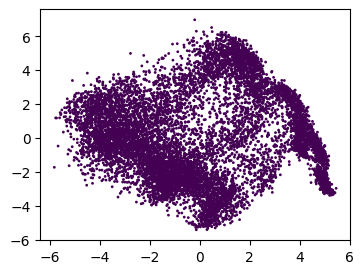

In [4]:
plt.figure(figsize=(4, 3))
show_pca_proj(np.zeros(pca_proj.shape[1]))
plt.show()

In [4]:
with open("./data/pca_proj.pkl", "wb") as fp:
    pkl.dump(pca_proj, fp)

## remove lead-lag ratio

In [5]:
data_r = align_data_sub["data"][:-4]
row_labels_r = align_data_sub["row_labels"][:-4]

eval_r, evec_r, _, cov_mat = hc.pca(data_r)
pca_proj_r = np.dot(evec_r.T, data_r)

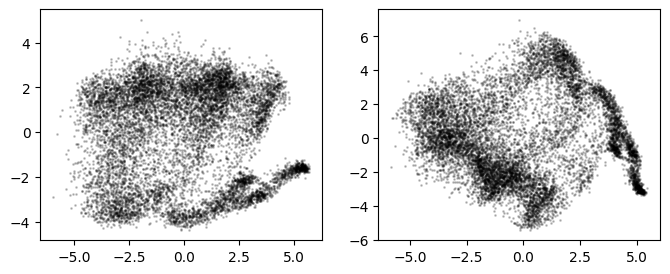

In [6]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(pca_proj_r[0], pca_proj_r[1], 1, 'k', facecolor="none", alpha=0.2)
plt.subplot(122)
plt.scatter(pca_proj[0], pca_proj[1], 1, 'k', facecolor="none", alpha=0.2)
plt.show()

## Check dynamics by index

In [7]:
def get_sq_idx(idx):
    na = idx // (15 * 3 * 16)
    nb = (idx - 15*3*16*na) // (3 * 16)
    nr = (idx - 15*3*16*na - 3*16*nb) // 16
    nw = idx - 15*3*16*na - 3*16*nb - 16*nr
    return na, nb, nr, nw


def get_idx(sq_idx):
    return sq_idx[0]*15*3*16 + sq_idx[1]*3*16 + sq_idx[2]*16 + sq_idx[3]

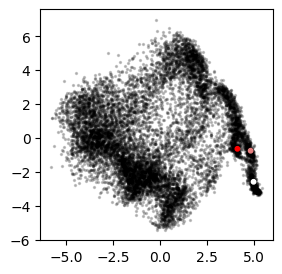

In [11]:
target_idx = [3475, 7714, 7859]

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0], pca_proj[1],2, 'k', alpha=0.2, facecolor="none")
plt.scatter(pca_proj[0][target_idx], pca_proj[1][target_idx], 10, [[1, 0, 0], [0.9, 0.5, 0.5], [1, 1, 1]])
plt.show()

# plt.figure(figsize=(5, 3))
# for i in target_idx:
#     plt.plot(data[:, i], 'o-')
# plt.show()

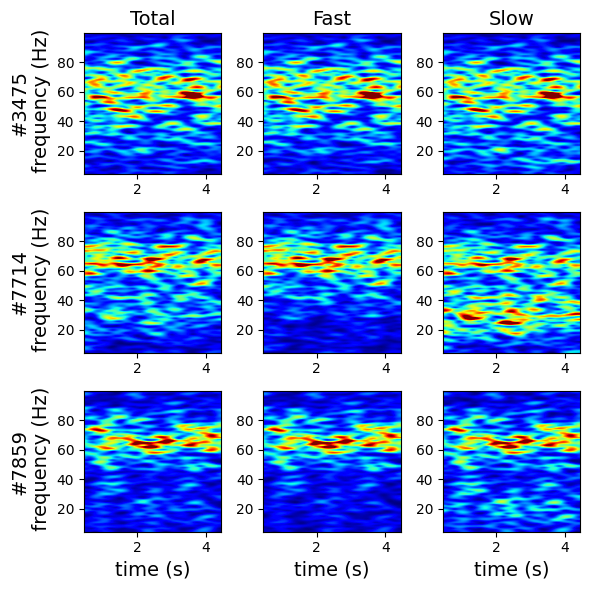

In [12]:
import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal

summary = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)

plt.figure(figsize=(6, 6))
nuse = 1
axs = []
for idx in target_idx:
    idx_sq = get_sq_idx(idx)
    data = summary.load_detail(*idx_sq, 0)

    for v in data["vlfp"]:
        psd, fpsd, tpsd = hhsignal.get_stfft(v, data["ts"], 2000, frange=(5, 100))

        ax = plt.subplot(3, 3, nuse)
        hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic")
        
        nuse += 1
        axs.append(ax)

lbs = ("Total", "Fast", "Slow")
for i in range(3):
    axs[3*i].set_ylabel("#%d\n frequency (Hz)"%(target_idx[i]), fontsize=14)
    axs[6+i].set_xlabel("time (s)", fontsize=14)
    axs[i].set_title("%s"%(lbs[i]), fontsize=14)

plt.tight_layout()
plt.show()

# K-means clustering

In [8]:
from sklearn.metrics import silhouette_score

# load result
with open("./data/kmeans_pred.pkl", "rb") as fp:
    pred_data = pkl.load(fp)
print(len(pred_data["labels"]))

2700


In [9]:
import warnings
warnings.filterwarnings(action='ignore')

@njit 
def build_consensus_matrix(pred_set, sval_set=None):
    
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    sval_set = np.ones(N) if sval_set is None else sval_set
    cmat = np.zeros((npoint, npoint))
    
    for n in range(N):
        s = sval_set[n]
        pred = pred_set[n]
        for i in range(npoint):
            cmat[i, i] += s
            for j in range(i+1, npoint):
                if pred[i] == pred[j]:
                    cmat[i, j] += s
                # cmat[j, i] = cmat[i, j]
    
    cmat = cmat / cmat[0, 0]
    for i in range(npoint):
        for j in range(i):
            cmat[i, j] = cmat[j, i]
     
    
    return cmat    


# compute sval
# # x = align_data_sub["data"]
# # N = x.shape[1]
# # NC = len(pred_data["labels"])

# pred_sval = np.zeros(NC)
# for i in trange(NC):
#     pred_sval[i] = silhouette_score(x.T, np.array(pred_data["labels"][i]), sample_size=1000)
    
# # compute consensus matrix
# nitr = 100
# e = np.linspace(0, 1, 21)
# ksets = np.arange(3, 30)
# c_hists = []
# # for i in trange(len(ksets)):
# for i in trange(10):
#     # cmat = build_consensus_matrix(pred_data["labels"][i*nitr:(i+1)*nitr], pred_sval[i*nitr:(i+1)*nitr])
#     cmat = build_consensus_matrix(pred_data["labels"][i*nitr:(i+1)*nitr])
#     c, _ = np.histogram(cmat.flatten(), e)
#     c_hists.append(c/np.sum(c))


In [23]:
@njit 
def build_consensus_matrix(pred_set, sval_set=None):
    
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    sval_set = np.ones(N) if sval_set is None else sval_set
    cmat = np.zeros((npoint, npoint))
    
    for n in range(N):
        s = sval_set[n]
        pred = pred_set[n]
        for i in range(npoint):
            cmat[i, i] += s
            for j in range(i+1, npoint):
                if pred[i] == pred[j]:
                    cmat[i, j] += s
                # cmat[j, i] = cmat[i, j]
    
    cmat = cmat / cmat[0, 0]
    for i in range(npoint):
        for j in range(i):
            cmat[i, j] = cmat[j, i]
     
    return np.round(cmat, 8)


@njit
def accumulate_evidence(pred_set):
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    
    cmat = np.zeros((npoint, npoint))
    for i in range(npoint):
        cmat[i, i] = 1
        for j in range(i+1, npoint):
            for n in range(N):
                if pred_set[n, i] == pred_set[n, j]:
                    cmat[i, j] += 1/N
            cmat[j, i] = cmat[i, j]
    
    return np.round(cmat, 8)

In [24]:
lb = pred_data["labels"][:100]
c1 = build_consensus_matrix(lb)
c2 = accumulate_evidence(lb)

In [20]:
# d  =c1.astype(np.float16) - c2.astype(np.float16)
d = np.round(c1, 8) - np.round(c2, 8)

In [62]:
c_hists_tmp = []
for c in c_hists:
    c = c[0]
    c_hists_tmp.append(c/np.sum(c))

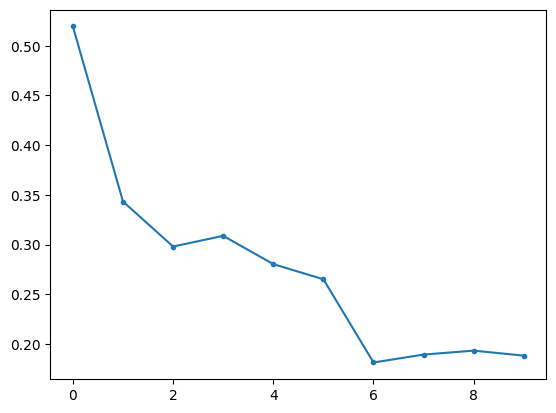

In [112]:
# pac = [c[-2] - c[1] for c in c_hists_tmp]
pac = []
for c in c_hists:
    cc = np.cumsum(c)
    pac.append(cc[-1] - c[0])
    
plt.plot(pac, '.-')

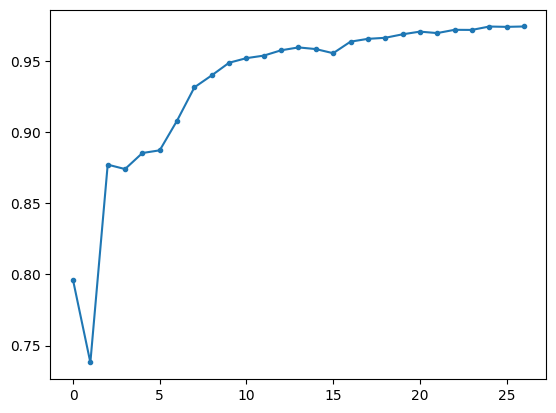

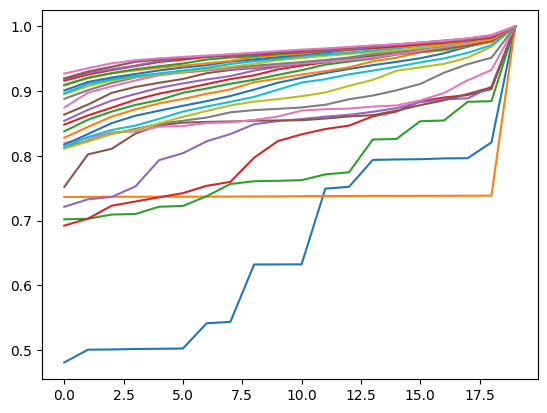

In [71]:
for i in range(27):
    plt.plot(np.cumsum(c_hists_tmp[i]))

In [28]:
hists = []
nmax = 100
for n in trange(10):
    pred_labels = np.array(pred_data["labels"][n*nmax:(n+1)*nmax])
    
    # cmat = accumulate_evidence(pred_labels)
    cmat = build_consensus_matrix(pred_labels)
    nbin, _ = np.histogram(cmat, np.linspace(0, 1, 21))
    hists.append(nbin/np.sum(nbin))    

  0%|          | 0/10 [00:00<?, ?it/s]

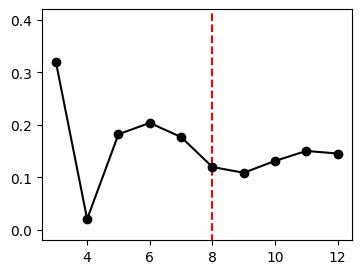

In [30]:
pacs = []
for i in range(len(hists)):
    c = np.cumsum(hists[i])
    pacs.append(c[-2] - c[1])
    
# ksets = np.arange(3, 30)
ksets = np.arange(3, 13)
plt.figure(figsize=(4, 3))
plt.plot(ksets, pacs, 'ko-')
plt.vlines(8, -1, 1, 'r', linestyles='--', zorder=-1)
plt.ylim([-0.02, 0.42])
plt.show()

In [31]:
hists = []
nmax = 100
for n in trange(10):
    pred_labels = np.array(pred_data["labels"][n*nmax:(n+1)*nmax])
    
    cmat = accumulate_evidence(pred_labels)
    nbin, _ = np.histogram(cmat, np.linspace(0, 1, 21))
    hists.append(nbin/np.sum(nbin))    

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
pacs = []
for i in range(len(hists)):
    c = np.cumsum(hists[i])
    pacs.append(c[-2] - c[1])

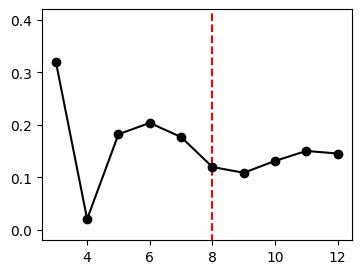

In [33]:
ksets = np.arange(3, 13)
plt.figure(figsize=(4, 3))
plt.plot(ksets, pacs, 'ko-')
plt.vlines(8, -1, 1, 'r', linestyles='--', zorder=-1)
plt.ylim([-0.02, 0.42])
plt.show()

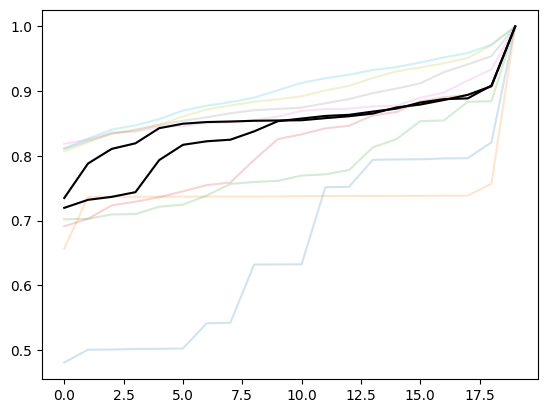

In [44]:
for i in range(10):
    plt.plot(np.cumsum(hists[i]), alpha=0.2)
plt.plot(np.cumsum(hists[5]), c='k')
plt.plot(np.cumsum(hists[4]), c='k')    

In [34]:
pred_labels = np.array(pred_data["labels"][6*nmax:7*nmax])
cmat = accumulate_evidence(pred_labels)

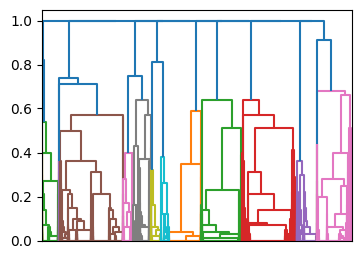

In [35]:
dmat = 1 - cmat
dmat[dmat <= 0] = 0

model_tree = hc.SLHC(metric="precomputed", method="complete")
model_tree.fit(dmat)
# pred_labels = model_tree.cut_dend(N=100)

plt.figure(figsize=(4, 3))
model_tree.draw_dend()
plt.show()

In [36]:
labels = model_tree.cut_dend(N=9)

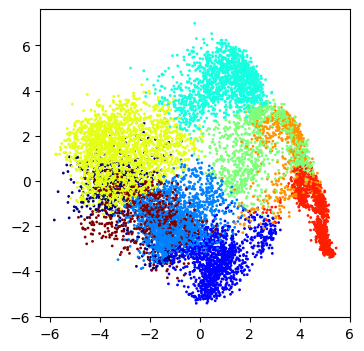

[ 699. 1215. 1898. 1424.  979. 2235.  607. 1144.  599.]


In [38]:
plt.figure(figsize=(4, 4))
show_pca_proj(labels, cmap="jet")
plt.show()

nums = np.zeros(9)
for n in labels:
    nums[n-1] += 1
print(nums)

## Draw cluster properties

In [265]:
lb = align_data_sub["row_labels"]

for cid in range(1, 9):
    plt.figure(figsize=(8, 3))
    plt.plot(align_data_sub["data"][:, labels==cid], 'k', alpha=0.01)
    y = align_data_sub["data"][:, labels==cid]
    y = np.median(y, axis=1)
    plt.plot(y, 'ro-', lw=2)
    plt.ylim([-8, 8])
    plt.xticks(np.arange(len(lb)), lb, rotation=60)
    plt.tight_layout()
    plt.savefig("./figs/cluster_features/cid%d.png"%(cid))
    plt.clf()

    # plt.show()

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

## Baseline

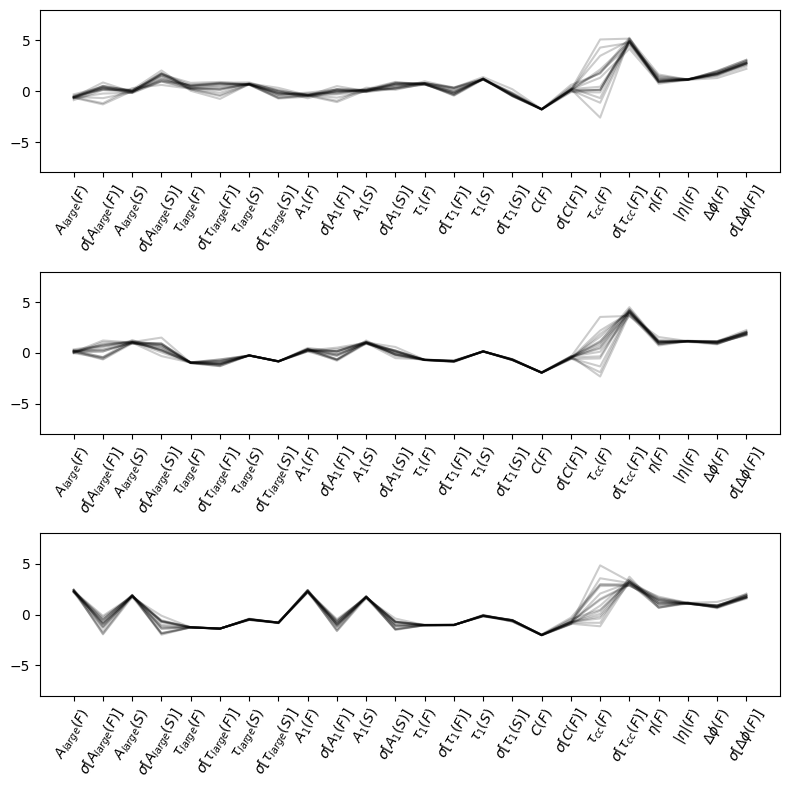

In [267]:
x_base = []

plt.figure(figsize=(8, 8))
for nr in range(3):
    plt.subplot(3,1,nr+1)
    base_idx = [get_idx([0, 0, nr, nw]) for nw in range(16)]
    data_base = align_data_sub["data"][:, base_idx]
    plt.plot(data_base, c='k', alpha=0.2)
    x_base.append(data_base.mean(axis=1))
    plt.xticks(np.arange(len(lb)), lb, rotation=60)
    plt.ylim([-8, 8])
plt.tight_layout()
plt.show()

# Draw on square lattice

In [269]:
sz = [15, 15, 3, 16]
sq_cid = labels.reshape(*sz)

x = np.linspace(0, 1, 15) # beta
y = np.linspace(0, 2, 15) # alpha
r = [0, 0.5, 1]
w = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]

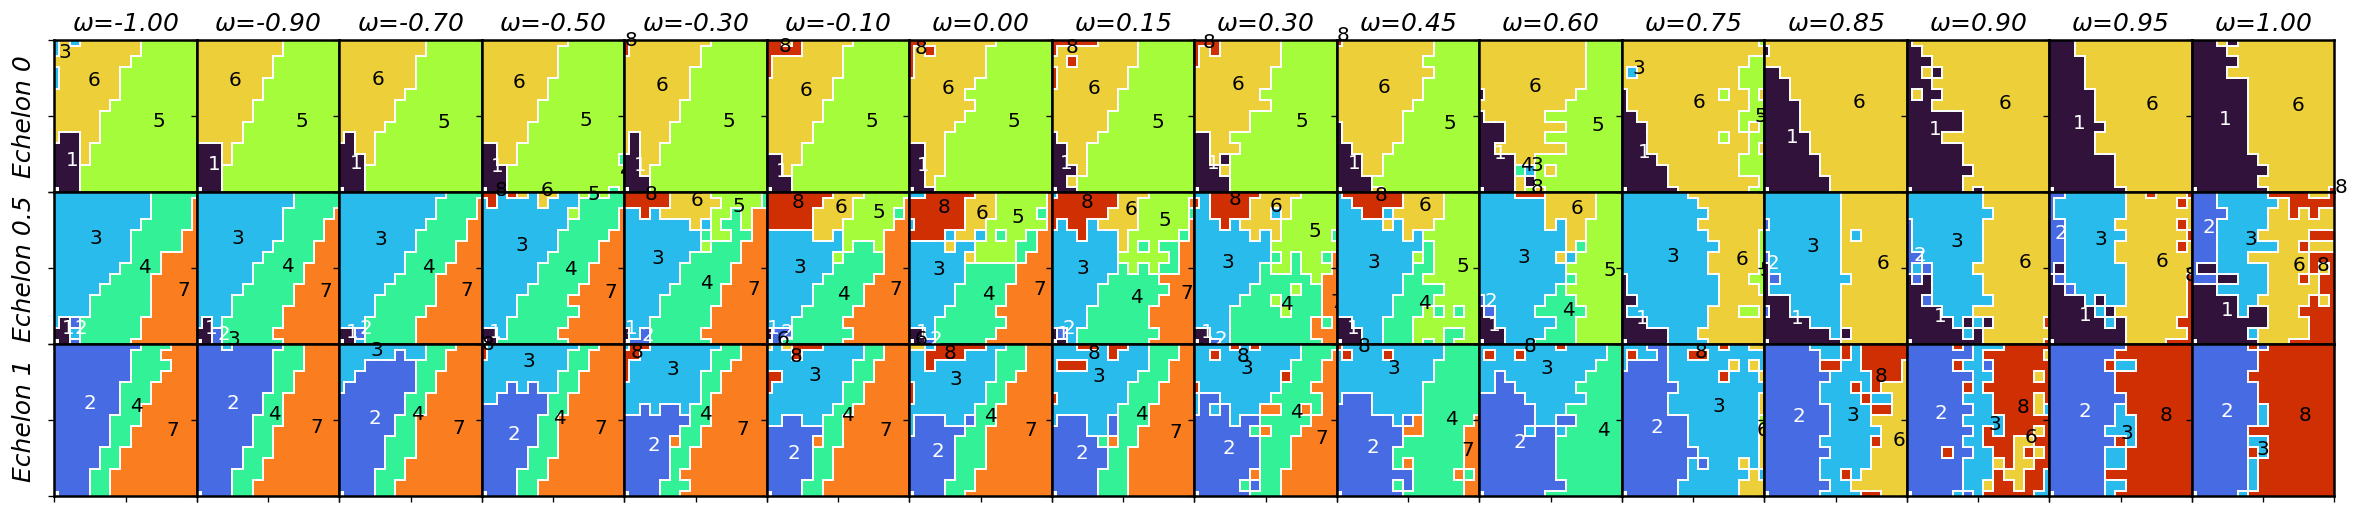

In [270]:
hc.show_cluster_summary(sq_cid, wsets=w, max_cid=9, min_cid=1, sval=None)
plt.show()

## compare feature values with baseline value

### CID1

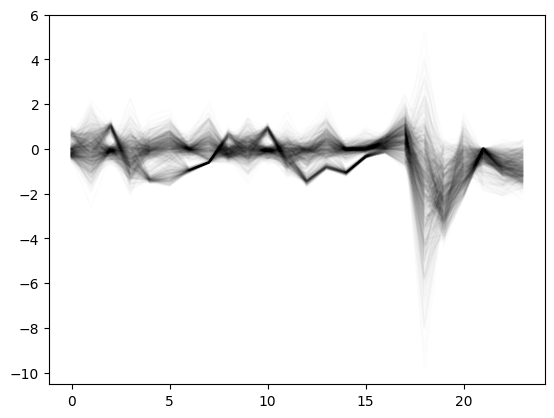

In [276]:
y = align_data_sub["data"][:, labels==1]
yb = x_base[0]

x = np.arange(len(lb))
plt.figure()
plt.plot(x, y-yb[:, None], 'k', alpha=0.01)
plt.show()

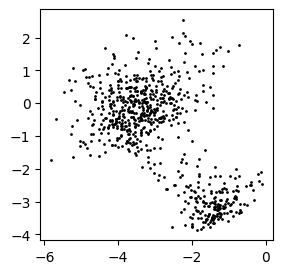

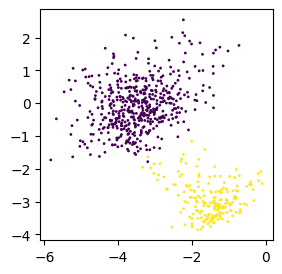

In [320]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==1], pca_proj[1][labels==1], c='k', s=1)
plt.show()

from sklearn.cluster import KMeans

kobj = KMeans(2, n_init=10)
lb_sub = kobj.fit_predict(data[:, labels==1].T.copy())

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==1], pca_proj[1][labels==1], c=lb_sub, s=1)
plt.show()

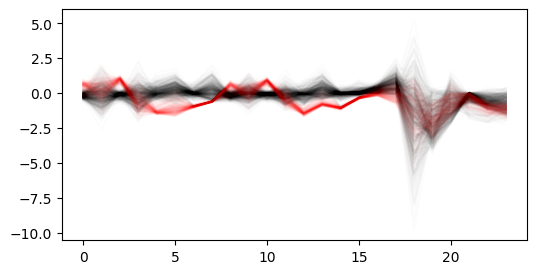

In [319]:
y = align_data_sub["data"][:, labels==1]
yb = x_base[0]

x = np.arange(len(lb))
y1 = y[:, lb_sub == 0]
y2 = y[:, lb_sub == 1]

plt.figure(figsize=(6, 3))
plt.plot(x, y1-yb[:, None], 'k', alpha=0.01)
plt.plot(x, y2-yb[:, None], 'r', alpha=0.01)
plt.show()

### CID2

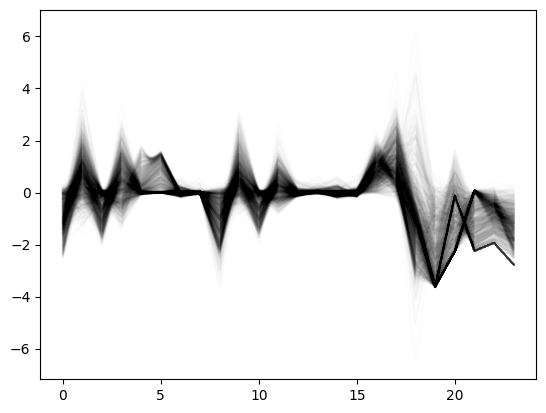

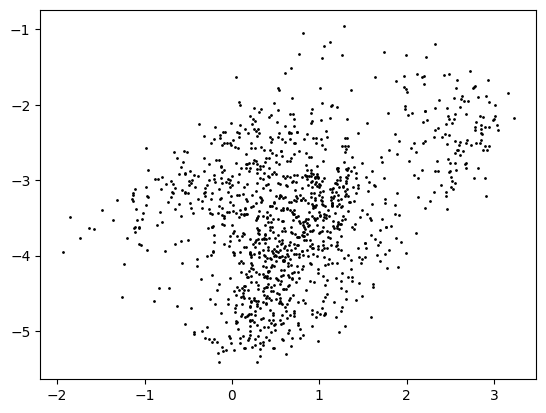

In [322]:
y = align_data_sub["data"][:, labels==2]
yb = x_base[2]

x = np.arange(len(lb))
plt.figure()
plt.plot(x, y-yb[:, None], 'k', alpha=0.01)
plt.show()

plt.figure()
plt.scatter(pca_proj[0][labels==2], pca_proj[1][labels==2], c='k', s=1)
plt.show()

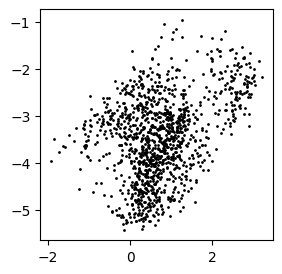

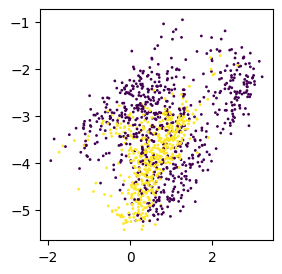

In [338]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==2], pca_proj[1][labels==2], c='k', s=1)
plt.show()

from sklearn.cluster import KMeans

kobj = KMeans(2, n_init=10)
lb_sub = kobj.fit_predict(data[:, labels==2].T.copy())

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==2], pca_proj[1][labels==2], c=lb_sub, s=1)
plt.show()

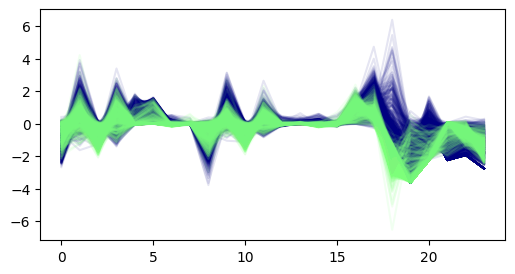

In [342]:
y = align_data_sub["data"][:, labels==2]
yb = x_base[2]

x = np.arange(len(lb))
cmap = hhtools.get_palette("jet")
max_idx = 3

plt.figure(figsize=(6, 3))
for idx in range(max_idx):
    plt.plot(x, y[:, lb_sub==idx]-yb[:, None], c=cmap(idx/(max_idx-1)), alpha=0.1)

plt.show()

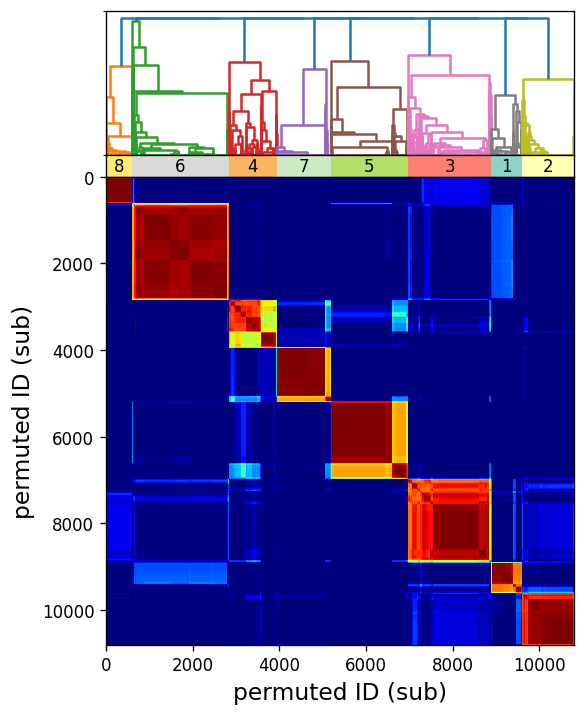

In [82]:
def draw_with_dendrogram(res_linkage, cmat, cluster_id, label=None):
    from scipy.cluster.hierarchy import dendrogram
    
    num = res_linkage.shape[0]
    
    fig = plt.figure(dpi=120, figsize=(6, 6))
    fig.add_axes([0.15, 0.78, 0.65, 0.2])
    dendrogram(res_linkage, no_labels=True, color_threshold=max(res_linkage[:, 2]))
    # dendrogram(res_link, no_labels=True, color_threshold=max(res_link[:, 2])*1)
    plt.yscale("symlog")
    plt.xticks([]); plt.yticks([])
    # plt.xlim([0, num-1])

    fig.add_axes([0.15, 0.75, 0.65, 0.03])
    plt.imshow(cluster_id.reshape((1, -1)), aspect="auto", cmap="Set3", interpolation="none")
    for cid in np.unique(cluster_id):
        x = np.where(cluster_id == cid)[0]
        plt.text(np.average(x), 0, "%d"%(cid), ha='center', va="center")
    plt.xticks([]); plt.yticks([])
    plt.xlim([0, num-1])

    fig.add_axes([0.15, 0.1, 0.65, 0.65])
    plt.imshow(cmat, cmap="jet")
    plt.xlabel(label, fontsize=14)
    plt.ylabel(label, fontsize=14)

    # plt.show()
    return fig

sorted_mat, sort_id = model_tree.sort_dmat(cmat.copy())
fig = draw_with_dendrogram(model_tree.linkmat, sorted_mat, labels[sort_id], label="permuted ID (sub)")

In [77]:
len(sort_id)

10800

## visualization

# Apply evidence accumulation clustering (EAC) method

In [136]:
@njit
def accumulate_evidence(pred_set):
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    
    cmat = np.zeros((npoint, npoint))
    for i in range(npoint):
        cmat[i, i] = 1
        for j in range(i+1, npoint):
            for n in range(N):
                if pred_set[n, i] == pred_set[n, j]:
                    cmat[i, j] += 1/N
            cmat[j, i] = cmat[i, j]
    return cmat


def pick_k():
    return np.random.randint(5, 50)


x = data.T.copy()

np.random.seed(500)

kuse = []
pred_labels = []

nitr = 300
for n in trange(nitr):
    K = pick_k()
    kobj = KMeans(n_clusters=K, copy_x=True, init="k-means++", n_init=1, random_state=None)
    lb = kobj.fit_predict(x)
    
    kuse.append(K)
    pred_labels.append(lb)
    # cmat += accumulate_evidence(np.array([lb]))/nitr

cmat = accumulate_evidence(np.array(pred_labels))
    
dmat = 1 - cmat.copy()
dmat[dmat <= 0] = 0

  0%|          | 0/300 [00:00<?, ?it/s]

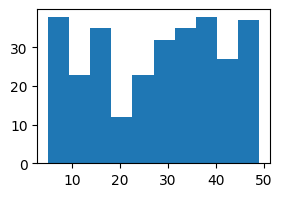

In [137]:
plt.figure(figsize=(3, 2))
plt.hist(kuse)
plt.show()

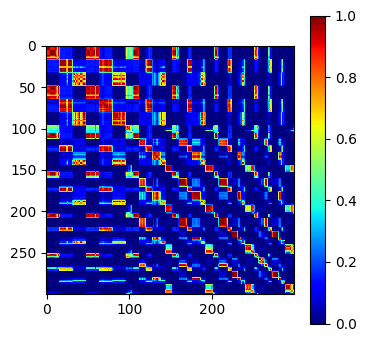

In [138]:
plt.figure(figsize=(4, 4))
plt.imshow(cmat[:300][:, :300], cmap="jet")
plt.colorbar()
plt.show()

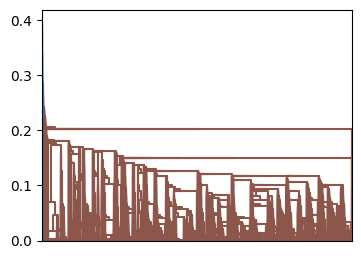

In [146]:
model_tree = hc.SLHC(metric="precomputed", method="single")
model_tree.fit(dmat)
pred_labels = model_tree.cut_dend(N=100)

plt.figure(figsize=(4,3))
model_tree.draw_dend()
plt.show()

In [149]:
np.unique(pred_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

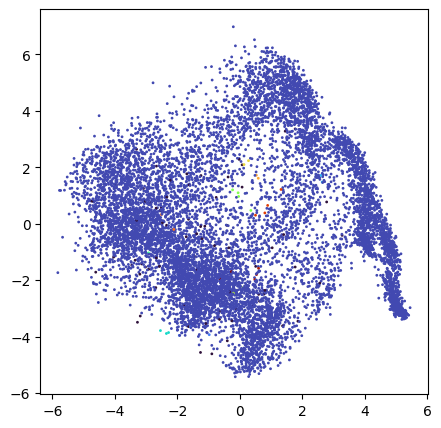

In [150]:
plt.figure(figsize=(5, 5))
show_pca_proj(pred_labels, cmap="turbo")
plt.show()